In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/pscratch/sd/x/xju/venv/llm/bin/python


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu118
True


In [4]:
import sys

sys.path.append("..")

## Check input data

In [5]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
input_data_dir = "../data"
dataset = "trackml"
data_dir = os.path.join(input_data_dir, dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

In [8]:
print(f"# of tokens: {train_data.shape[0]:,}")
tokens, counts = np.unique(train_data, return_counts=True)
print(f"# of tracks: {counts[0]:,}")

# of tokens: 105,997,605
# of tracks: 8,186,932


## Check data reader

In [5]:
from src.datamodules.trackml import TrackMLDataSet

In [6]:
val_dataset = TrackMLDataSet("../data/trackml_fixed_length/v1_evt10_val.bin", block_size=22, do_randomize=True)

In [33]:
type(val_dataset.data)

numpy.memmap

In [23]:
val_dataset.data.shape, val_dataset.block_size

((1784046,), 22)

In [25]:
val_dataset.data.shape[0] // val_dataset.block_size

81093

In [29]:
val_dataset[0]

(tensor([1246, 1907, 2949, 5595,    4,    7,    7,    7,    7,    7,    7,    7,
            7,    7,    7,    7,    7,    7,    7,    3, 6659, 8219]),
 tensor([1907, 2949, 5595,    4,    7,    7,    7,    7,    7,    7,    7,    7,
            7,    7,    7,    7,    7,    7,    3, 6659, 8219, 8220]))

In [30]:
val_dataset[0]

(tensor([   7,    7,    7,    7,    3, 1897, 2851, 5503, 6528, 6529, 7957, 7958,
         8035, 8036,    4,    7,    7,    7,    7,    7,    7,    7]),
 tensor([   7,    7,    7,    3, 1897, 2851, 5503, 6528, 6529, 7957, 7958, 8035,
         8036,    4,    7,    7,    7,    7,    7,    7,    7,    7]))

In [7]:
for data in val_dataset:
    break

In [10]:
data[0].shape, data[1].shape

(torch.Size([22]), torch.Size([22]))

In [11]:
val_dataset_norandom = TrackMLDataSet("../data/trackml_fixed_length/v1_evt10_val.bin", block_size=22, do_randomize=False)

In [31]:
for idx, data_norandom in enumerate(val_dataset_norandom):
    if idx > 2: 
        break
    print(data_norandom)

(tensor([   3, 3324, 3327, 3432, 3435, 3540, 3543, 3648, 3651, 3756, 3759, 3864,
        3974, 3976,    4,    7,    7,    7,    7,    7,    7,    7]), tensor([3324, 3327, 3432, 3435, 3540, 3543, 3648, 3651, 3756, 3759, 3864, 3974,
        3976,    4,    7,    7,    7,    7,    7,    7,    7,    3]))
(tensor([    3,   857,   858,  1143,  1583,  2229,  4668,  4836,  5007,  5186,
         5975, 12032, 12129,     4,     7,     7,     7,     7,     7,     7,
            7,     7]), tensor([  857,   858,  1143,  1583,  2229,  4668,  4836,  5007,  5186,  5975,
        12032, 12129,     4,     7,     7,     7,     7,     7,     7,     7,
            7,     3]))
(tensor([    3,   859,  1113,  1114,  1535,  1536,  4674,  4843,  4846,  5016,
         5148,  5149, 11934, 11936, 12033,     4,     7,     7,     7,     7,
            7,     7]), tensor([  859,  1113,  1114,  1535,  1536,  4674,  4843,  4846,  5016,  5148,
         5149, 11934, 11936, 12033,     4,     7,     7,     7,     7,     7,
 

In [14]:
data_norandom[0].shape, data_norandom[1].shape

(torch.Size([22]), torch.Size([22]))

In [17]:
data_norandom

(tensor([ 3314,  3423,  3531,  3641, 11095, 11265, 11437, 11607, 11779,     4,
             7,     7,     7,     7,     7,     7,     7,     7,     7,     3,
           963,  3300]),
 tensor([ 3423,  3531,  3641, 11095, 11265, 11437, 11607, 11779,     4,     7,
             7,     7,     7,     7,     7,     7,     7,     7,     3,   963,
          3300,  3303]))

## Performance

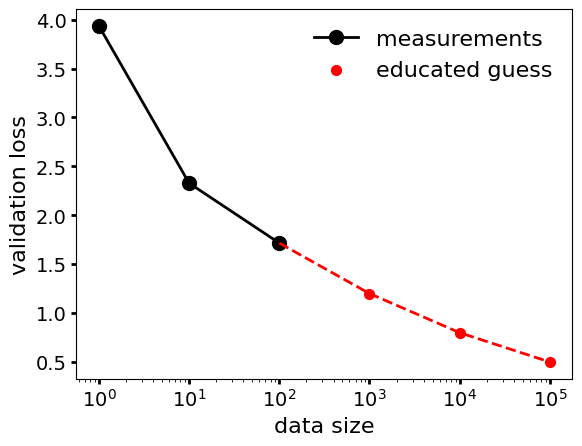

In [29]:
fontsize = 16
data_size = [1, 10, 100]
val_loss = [3.9347, 2.3281, 1.7158]

predict_data_size = [1000, 10_000, 100_000]
prdict_loss = [1.2, 0.8, 0.5]

fontsize = 16
plt.plot(data_size, val_loss, "k-o", label="measurements")
plt.xlabel("data size", fontsize=fontsize)
plt.ylabel("validation loss", fontsize=fontsize)
plt.xscale("log")
plt.scatter(predict_data_size, prdict_loss, c="r", s=50, label="educated guess")
plt.plot([100]+ predict_data_size, [1.7158] + prdict_loss, "r--")
plt.legend(fontsize=fontsize)


## nanoGPT input data

In [11]:
block_size = 1024
batch_size = 12
device = "cuda"
device_type = "cuda"

def get_batch(split: str = "train"):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [12]:
X, Y = get_batch('train')

In [14]:
X.shape, Y.shape

torch.Size([12, 1024])

In [16]:
X[0], Y[0]

tensor([47, 52, 58,  ...,  1, 51, 63], device='cuda:0')

## Prepare Tracking data

In [24]:
EVENT_START_TOKEN = 1
EVENT_END_TOKEN = 2
TRACK_START_TOKEN = 3
TRACK_END_TOKEN = 4
TRACK_HOLE_TOKEN = 5
UNKNOWN_TOKEN = 6
MASK_TOKEN = 7
PAD_TOKEN = 8

block_size = 18 + 2  # maximum number of hits for one track + START + END

In [25]:
import os
import numpy as np
import pandas as pd

## Reproduce umid_dict the same way as in process_data
input_dir = "/home/xju/ocean/data/TrackML/codalab_data"
detector_path = 'detector.csv'

In [124]:

detector = pd.read_csv(Path(input_dir) / detector_path)

detector_umid = np.stack([detector.volume_id, detector.layer_id, detector.module_id], axis=1)
umid_dict = {}
index = 7
for i in detector_umid:
    umid_dict[tuple(i)] = index
    index += 1

## Inverting the umid_dict
umid_dict_inv = {v: k for k, v in umid_dict.items()}

In [12]:
pixel_moudels = [k for k in umid_dict.keys() if k[0] in [7, 8, 9]]

In [70]:
vocab_size = len(pixel_moudels)
print("# of pixel moduels: ", vocab_size)
print("# of all modules: ", len(umid_dict))

# of pixel moduels:  4004
# of all modules:  18728


## Torch Text

In [52]:
# import datasets
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')

def tokenize(label, line):
    return line.split()

tokens = []
for label, line in train_iter:
    tokens += tokenize(label, line)
    break

In [54]:
label, line

(1,
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

In [55]:
tokens

['I',
 'rented',
 'I',
 'AM',
 'CURIOUS-YELLOW',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967.',
 'I',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'U.S.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country,',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 '"controversial"',
 'I',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself.<br',
 '/><br',
 '/>The',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'Swedish',
 'drama',
 'student',
 'named',
 'Lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life.',
 'In',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attentions',
 'to',
 'making',
 'some',
 'sort',
 'of',
 'documentary',
 'on',
 'what',
 'the',
 'average',
 'Swede',
 'thought',
 'about',
 'certai